In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16

In [3]:
file_name = 'wheat_21_var_3_species.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 1
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(33868, 147, 1)
(8468, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 900,195
Trainable params: 900,195
Non-trainable params: 0
__________________________________________________

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
2117/2117 - 29s - loss: 0.8709 - accuracy: 0.5744 - 29s/epoch - 14ms/step
for training
1059/1059 [==============================] - 5s 4ms/step - loss: 0.5459 - accuracy: 0.7690
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.5400 - accuracy: 0.7722

Epoch:  2
2117/2117 - 26s - loss: 0.4424 - accuracy: 0.8173 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.3211 - accuracy: 0.8781
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.3173 - accuracy: 0.8781

Epoch:  3
2117/2117 - 26s - loss: 0.2879 - accuracy: 0.8888 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.2352 - accuracy: 0.9114
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.2333 - accuracy: 0.9118

Epoch:  4
2117/2117 - 27s - loss: 0.2423 - accuracy: 0.9060 - 27s/epoch - 13ms/step
for training
1059/1059 [=====================

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1005 - accuracy: 0.9610
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0980 - accuracy: 0.9633

Epoch:  30
2117/2117 - 26s - loss: 0.0624 - accuracy: 0.9776 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0456 - accuracy: 0.9848
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0515 - accuracy: 0.9817

Epoch:  31
2117/2117 - 26s - loss: 0.0641 - accuracy: 0.9771 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0509 - accuracy: 0.9806
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0547 - accuracy: 0.9808

Epoch:  32
2117/2117 - 26s - loss: 0.0603 - accuracy: 0.9780 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0737 - accuracy: 0.9743
for testing
265/265 [==

1059/1059 [==============================] - 5s 4ms/step - loss: 0.0301 - accuracy: 0.9897
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0351 - accuracy: 0.9888

Epoch:  58
2117/2117 - 28s - loss: 0.0378 - accuracy: 0.9864 - 28s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0255 - accuracy: 0.9916
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0316 - accuracy: 0.9897

Epoch:  59
2117/2117 - 26s - loss: 0.0410 - accuracy: 0.9849 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0383 - accuracy: 0.9855
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0473 - accuracy: 0.9831

Epoch:  60
2117/2117 - 26s - loss: 0.0375 - accuracy: 0.9863 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1200 - accuracy: 0.9552
for testing
265/265 [===============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0284 - accuracy: 0.9888
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0369 - accuracy: 0.9878

Epoch:  86
2117/2117 - 26s - loss: 0.0325 - accuracy: 0.9882 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0223 - accuracy: 0.9919
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.9890

Epoch:  87
2117/2117 - 26s - loss: 0.0289 - accuracy: 0.9894 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0406 - accuracy: 0.9859
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0530 - accuracy: 0.9835

Epoch:  88
2117/2117 - 28s - loss: 0.0292 - accuracy: 0.9887 - 28s/epoch - 13ms/step
for training
1059/1059 [==============================] - 5s 5ms/step - loss: 0.0317 - accuracy: 0.9889
for testing
265/265 [===============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0703 - accuracy: 0.9750
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0809 - accuracy: 0.9744

Epoch:  114
2117/2117 - 26s - loss: 0.0229 - accuracy: 0.9918 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0304 - accuracy: 0.9888
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0437 - accuracy: 0.9861

Epoch:  115
2117/2117 - 26s - loss: 0.0231 - accuracy: 0.9914 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0488 - accuracy: 0.9818
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0619 - accuracy: 0.9791

Epoch:  116
2117/2117 - 26s - loss: 0.0252 - accuracy: 0.9907 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0247 - accuracy: 0.9908
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0505 - accuracy: 0.9822
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0682 - accuracy: 0.9765

Epoch:  142
2117/2117 - 26s - loss: 0.0183 - accuracy: 0.9932 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 5s 4ms/step - loss: 0.0180 - accuracy: 0.9931
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0334 - accuracy: 0.9908

Epoch:  143
2117/2117 - 27s - loss: 0.0195 - accuracy: 0.9927 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0129 - accuracy: 0.9953
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0247 - accuracy: 0.9916

Epoch:  144
2117/2117 - 26s - loss: 0.0209 - accuracy: 0.9922 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0146 - accuracy: 0.9947
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0074 - accuracy: 0.9976
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9927

Epoch:  170
2117/2117 - 26s - loss: 0.0174 - accuracy: 0.9934 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0345 - accuracy: 0.9869
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0538 - accuracy: 0.9838

Epoch:  171
2117/2117 - 27s - loss: 0.0185 - accuracy: 0.9938 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0084 - accuracy: 0.9968
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.9916

Epoch:  172
2117/2117 - 26s - loss: 0.0165 - accuracy: 0.9942 - 26s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0086 - accuracy: 0.9971
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0058 - accuracy: 0.9980
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0206 - accuracy: 0.9942

Epoch:  198
2117/2117 - 26s - loss: 0.0151 - accuracy: 0.9946 - 26s/epoch - 12ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0055 - accuracy: 0.9981
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0209 - accuracy: 0.9939

Epoch:  199
2117/2117 - 27s - loss: 0.0147 - accuracy: 0.9948 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0045 - accuracy: 0.9987
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0207 - accuracy: 0.9932

Epoch:  200
2117/2117 - 27s - loss: 0.0149 - accuracy: 0.9947 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0179 - accuracy: 0.9930
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0052 - accuracy: 0.9985
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0220 - accuracy: 0.9934

Epoch:  226
2117/2117 - 27s - loss: 0.0111 - accuracy: 0.9963 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0078 - accuracy: 0.9969
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0250 - accuracy: 0.9926

Epoch:  227
2117/2117 - 27s - loss: 0.0135 - accuracy: 0.9950 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0213 - accuracy: 0.9922
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0379 - accuracy: 0.9882

Epoch:  228
2117/2117 - 27s - loss: 0.0110 - accuracy: 0.9964 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0356 - accuracy: 0.9864
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0140 - accuracy: 0.9944
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0406 - accuracy: 0.9893

Epoch:  254
2117/2117 - 27s - loss: 0.0113 - accuracy: 0.9963 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0153 - accuracy: 0.9948
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0323 - accuracy: 0.9920

Epoch:  255
2117/2117 - 27s - loss: 0.0110 - accuracy: 0.9962 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0092 - accuracy: 0.9965
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9922

Epoch:  256
2117/2117 - 27s - loss: 0.0110 - accuracy: 0.9960 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0024 - accuracy: 0.9995
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0405 - accuracy: 0.9862
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0591 - accuracy: 0.9836

Epoch:  282
2117/2117 - 27s - loss: 0.0102 - accuracy: 0.9964 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0030 - accuracy: 0.9993
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0228 - accuracy: 0.9934

Epoch:  283
2117/2117 - 27s - loss: 0.0101 - accuracy: 0.9961 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0033 - accuracy: 0.9991
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0195 - accuracy: 0.9940

Epoch:  284
2117/2117 - 28s - loss: 0.0100 - accuracy: 0.9963 - 28s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0051 - accuracy: 0.9981
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0040 - accuracy: 0.9987
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0206 - accuracy: 0.9944

Epoch:  310
2117/2117 - 27s - loss: 0.0048 - accuracy: 0.9984 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0022 - accuracy: 0.9994
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0206 - accuracy: 0.9943

Epoch:  311
2117/2117 - 27s - loss: 0.0125 - accuracy: 0.9957 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0047 - accuracy: 0.9982
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0283 - accuracy: 0.9922

Epoch:  312
2117/2117 - 27s - loss: 0.0082 - accuracy: 0.9972 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0152 - accuracy: 0.9940
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0040 - accuracy: 0.9988
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0243 - accuracy: 0.9933

Epoch:  338
2117/2117 - 27s - loss: 0.0101 - accuracy: 0.9967 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0013 - accuracy: 0.9997
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0243 - accuracy: 0.9947

Epoch:  339
2117/2117 - 27s - loss: 0.0080 - accuracy: 0.9975 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0017 - accuracy: 0.9995
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.9937

Epoch:  340
2117/2117 - 27s - loss: 0.0070 - accuracy: 0.9978 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0020 - accuracy: 0.9994
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0094 - accuracy: 0.9962
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0294 - accuracy: 0.9923

Epoch:  366
2117/2117 - 27s - loss: 0.0087 - accuracy: 0.9969 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0023 - accuracy: 0.9992
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9939

Epoch:  367
2117/2117 - 27s - loss: 0.0061 - accuracy: 0.9979 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0022 - accuracy: 0.9994
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0211 - accuracy: 0.9937

Epoch:  368
2117/2117 - 27s - loss: 0.0093 - accuracy: 0.9974 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0031 - accuracy: 0.9990
for testing
265/265 [============

1059/1059 [==============================] - 4s 4ms/step - loss: 0.0239 - accuracy: 0.9913
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0536 - accuracy: 0.9850

Epoch:  394
2117/2117 - 28s - loss: 0.0057 - accuracy: 0.9984 - 28s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0511 - accuracy: 0.9802
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0850 - accuracy: 0.9782

Epoch:  395
2117/2117 - 27s - loss: 0.0065 - accuracy: 0.9977 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0320 - accuracy: 0.9884
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9854

Epoch:  396
2117/2117 - 27s - loss: 0.0078 - accuracy: 0.9975 - 27s/epoch - 13ms/step
for training
1059/1059 [==============================] - 5s 4ms/step - loss: 0.0080 - accuracy: 0.9975
for testing
265/265 [============

In [24]:
history_dataframe

,loss,accuracy
0,0.870918,0.574377
1,0.442385,0.817291
2,0.287906,0.888774
3,0.242319,0.906017
4,0.219126,0.915584
...,...,...
395,0.007820,0.997520
396,0.010959,0.996988
397,0.002052,0.999203
398,0.009844,0.996752


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

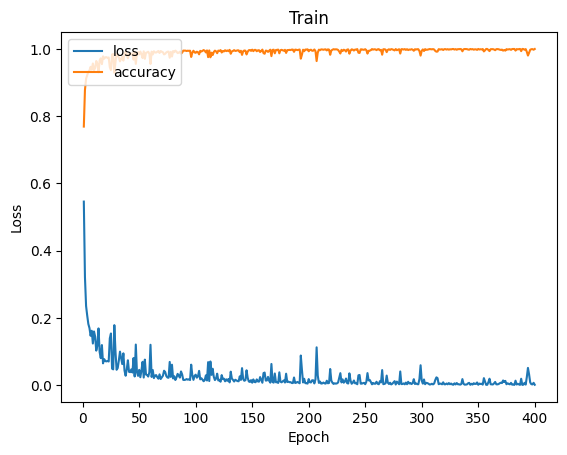

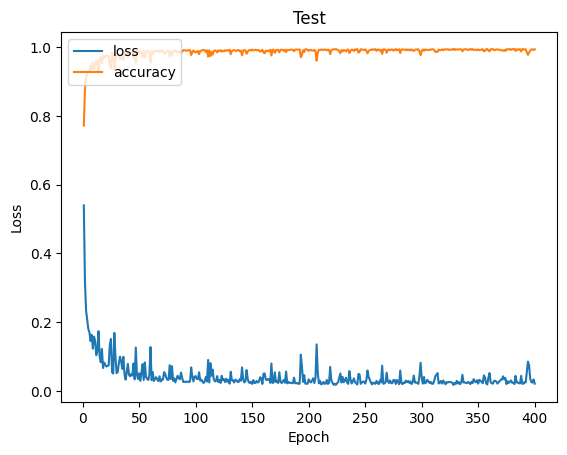

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])